In [2]:
import numpy as np
import control
from bokeh.plotting import figure
from bokeh.io import show, output_notebook

In [3]:
# Plot tooltips
TOOLTIPS = [
    ("index", "$index"),
    ("(t, val)", "($x, $y)"),
    ]

# Step 1: DC-DC single leg with current control
![dcdc_single_leg_current_control](dcdc_single_leg_current_control.png)

In [4]:
# Electrical parameters
L = 6e-3
Rload = 30
E = 600
fsw = 16e3

The controller is designed here with a compensation of the output voltage.

![current_control_with_voltage_compensation](current_control_with_voltage_compensation.png)

Closed loop transfer function : $$ TF_{CL}(p) = \dfrac{1 + \frac{K_p}{K_i} p}{1 + \frac{K_p}{K_i} p + \frac{L}{E ~ K_i} p^2 } $$

Which leads to:
$$ K_i = \dfrac{L \omega_n^2}{E}  ~~~~ \text{et} ~~~~  K_p = \dfrac{2 \xi K_i}{\omega_n} $$





### Step 1.a) compute $K_p$ and $K_i$ coefficients with $\xi = 0.707$ 
Parameter $\omega_n$ is chosen to get the same dynamic in closed loop as in open-loop with a nominal load (as this dynamic is high enough for this application) and the damping factor is limited to 0.707.

In [5]:
wn = Rload / L   # same dynamic as in open-loop
xi = 0.707
Ki = wn ** 2 * L / E
Kp = 2 * xi * Ki / wn
print(Kp)
print(Ki)

0.0707
250.0


Le's check the closed loop transfer function with these coefficients:

In [6]:
# Simulation of the transfer function with a step response
tf = control.tf(np.array([Kp / Ki, 1]), np.array([1 / wn**2, 2 * xi / wn, 1]))
simutime = np.linspace(0, 10 / wn, 1000)
(simutime, output) = control.step_response(tf, simutime, X0=0)
# Plot step response
step_response = figure(plot_width = 800, plot_height = 300, 
                       title = 'Step response',
                       x_axis_label = 'time (s)', y_axis_label = 'Output (p.u.)',
                       active_drag='box_zoom',
                       tooltips = TOOLTIPS)
step_response.line(simutime, output, color=(0, 50, 0))
output_notebook()
show(step_response)

AttributeError: unexpected attribute 'plot_width' to figure, similar attributes are outer_width, width or min_width

The overshoot of the step response can not be acceptable as it is around 20%. This is due to zero of the numerator of the transfer function which is probably too close to the real part of a denominator pole. Let's check this with the *pzmap* function of the control toolbox:

(array([-3535.+3536.06773125j, -3535.-3536.06773125j]),
 array([-3536.0678925+0.j]))

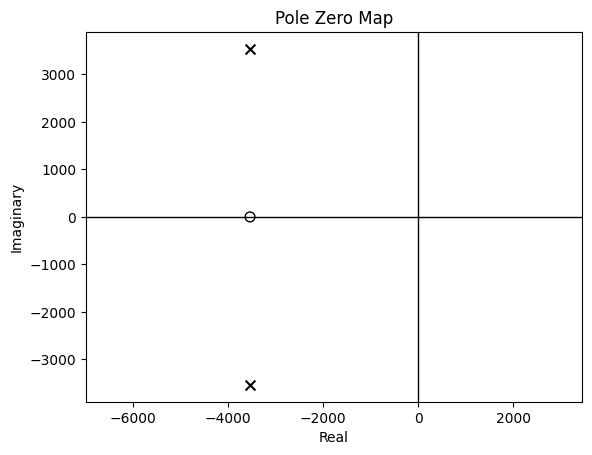

In [7]:
control.pzmap(tf, plot=True, grid=False, title='Pole Zero Map')

It confirms that thes $K_p$ and $K_i$ values lead to a zero in the transfer function which is too close to the poles. Different solutions can be considered to solve this issue. For example:
* increase the value of $\xi$.
* compensate the zero,

Let's try the first solution and perform a sweep of the damping coefficient $\xi$ to evaluate its influence on the overshoot and on the pole / zero map.

### Step 1.b) Sweep of the damping coefficient $\xi$

#### With the *step_response* function of the control package.

In [8]:
# Create figure
step_response_sweep = figure(plot_width = 800, plot_height = 300, 
                             title = 'Step response',
                             x_axis_label = 'time (s)', y_axis_label = 'Output (p.u.)',
                             active_drag='box_zoom',
                             tooltips = TOOLTIPS)
green_color = 25

# Step responses with xi parameter sweep
for xi in [0.7, 0.9, 1.1, 1.4]:
    Ki = wn ** 2 * L / E
    Kp = 2 * xi * Ki / wn
    tf = control.tf(np.array([Kp / Ki, 1]), np.array([1 / wn**2, 2 * xi / wn, 1]))
    (simutime, output) = control.step_response(tf, simutime, X0=0)
    step_response_sweep.line(simutime, output, color=(0, green_color, 0), legend_label='xi = ' + str(xi))
    green_color += 75
show(step_response_sweep)

AttributeError: unexpected attribute 'plot_width' to figure, similar attributes are outer_width, width or min_width

(array([-3535.+3536.06773125j, -3535.-3536.06773125j]),
 array([-3536.0678925+0.j]))

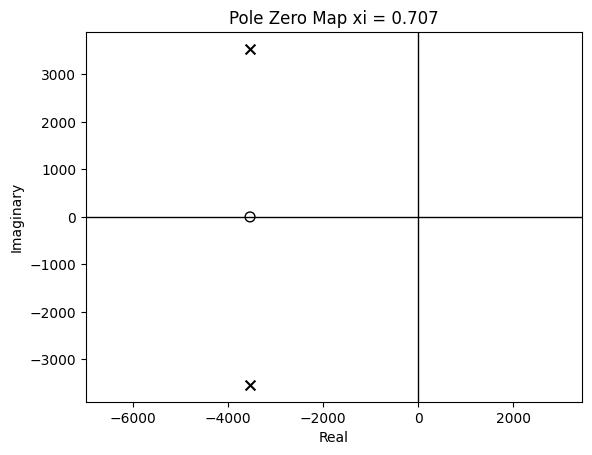

In [9]:
# plot pzmap for xi = 1.4
control.pzmap(tf, plot=True, grid=False, title='Pole Zero Map xi = ' + str(xi))

The $K_p$ and $K_i$ values obtained for a damping coefficient $\xi = 1.4$ seem to provide a good compromise between overshoot and speed.
Let's check this with some simba simulations for the different values of $\xi$.

#### With *Simba* simulations

In [10]:
import os
from aesim.simba import DesignExamples, ProjectRepository

# Get project design and PI bloc
file_path = os.path.join(os.getcwd(), "direct_current_power_flow_control.simba")
project = ProjectRepository(file_path)
direct_current_continuous_controller = project.GetDesignByName('direct_current_continuous_controller')
PI = direct_current_continuous_controller.Circuit.GetDeviceByName('PI')

# Figure
simba_sweep = figure(plot_width = 800, plot_height = 500, 
                             title = 'Simba simulation',
                             x_axis_label = 'time (s)', y_axis_label = 'Current (A)',
                             active_drag='box_zoom',
                             tooltips = TOOLTIPS)
green_color = 25                            

# Simba simulations and plot with xi parameter sweep
for xi in [0.7, 0.9, 1.1, 1.4]:
    Ki = wn ** 2 * L / E
    Kp = 2 * xi * Ki / wn
    PI.Kp = Kp
    PI.Ki = Ki
    sweep_job = direct_current_continuous_controller.TransientAnalysis.NewJob()
    status = sweep_job.Run()
    simba_time_continuous = sweep_job.TimePoints
    iL_continuous = sweep_job.GetSignalByName('L1 - Instantaneous Current').DataPoints
    simba_sweep.line(simba_time_continuous, iL_continuous, color=(0, green_color, 0), legend_label='xi = ' + str(xi))
    green_color += 75
show(simba_sweep)

AttributeError: unexpected attribute 'plot_width' to figure, similar attributes are outer_width, width or min_width

### Step 1.c) Discrete Z-controller : continuous to discrete transformation using Tustin method
The continuous to discrete transformation using Tustin method gives: $ p = \dfrac{2}{T_s} \dfrac{z-1}{z+1} $,

which leads to $ C(z) = \dfrac{1}{1-z^{-1}} \left(K_p + \frac{1}{2} K_i T_s + (- K_p + \frac{1}{2} K_i T_s) ~ z^{-1}\right) $

and then to the recurrence equation:
$$ \alpha(k) = \alpha(k-1) + \left(K_p + \frac{1}{2} K_i T_s \right) \epsilon(k) + \left(-K_p + \frac{1}{2} K_i T_s \right) \epsilon(k-1) $$

And finally: $ a_0 = -K_p + \frac{1}{2} K_i T_s $ and $ a_1 = K_p + \frac{1}{2} K_i T_s $

In [ ]:
Ts = 1 / fsw
a0 = -Kp + Ts * Ki / 2
a1 = Kp + Ts * Ki / 2
print('a0 = ', a0)
print('a1 = ', a1)

### Step 1.d) Simba Simulation: continuous and discrete controller

In [ ]:

# Load design with discrete controller
direct_current_discrete_controller = project.GetDesignByName('direct_current_discrete_controller')
a0_element = direct_current_discrete_controller.Circuit.GetDeviceByName('a0')
a1_element = direct_current_discrete_controller.Circuit.GetDeviceByName('a1')
a0_element.Value = a0
a1_element.Value = a1
discrete_job = direct_current_discrete_controller.TransientAnalysis.NewJob()
status = discrete_job.Run()

# Get results
simba_time_continuous =  sweep_job.TimePoints
iL_continuous =  sweep_job.GetSignalByName('L1 - Instantaneous Current').DataPoints
duty_cycle_continuous =  sweep_job.GetSignalByName('duty_cycle - Out').DataPoints

simba_time_discrete = discrete_job.TimePoints
iL_discrete = discrete_job.GetSignalByName('L1 - Instantaneous Current').DataPoints
duty_cycle_discrete = discrete_job.GetSignalByName('duty_cycle - Out').DataPoints

# plot
TOOLTIPS = [
    ("index", "$index"),
    ("(t, val)", "($x, $y)"),
    ]

# figure
current_control_fig = figure(plot_width = 800, plot_height = 300, 
                             title = 'Inductor current',
                             x_axis_label = 'time (s)', y_axis_label = 'Current (A)',
                             active_drag='box_zoom',
                             tooltips = TOOLTIPS)
current_control_fig.line(simba_time_continuous, iL_continuous, color='limegreen', legend_label='continuous')
current_control_fig.line(simba_time_discrete, iL_discrete, color='darkred', legend_label='discrete')

output_notebook()
show(current_control_fig)

# Step 2: Direct Current Power Flow Control
![direct_current_power_flow_control](direct_current_power_flow_control.png)



In [ ]:
# Simulate
direct_current_power_flow_control = project.GetDesignByName('direct_current_power_flow_control')
a0_element = direct_current_power_flow_control.Circuit.GetDeviceByName('a0')
a1_element = direct_current_power_flow_control.Circuit.GetDeviceByName('a1')
a0_element.Value = a0
a1_element.Value = a1
power_flow_control_job = direct_current_power_flow_control.TransientAnalysis.NewJob()
status = power_flow_control_job.Run()

# Results
simba_time_power_flow_control = power_flow_control_job.TimePoints
power_ref = power_flow_control_job.GetSignalByName('PowerRef - Out').DataPoints
power_average = power_flow_control_job.GetSignalByName('PowerEstimated - Out').DataPoints

# figure
p3 = figure(plot_width = 800, plot_height = 300, 
           title = 'Power',
           x_axis_label = 'time (s)', y_axis_label = 'Power (W)',
           active_drag='box_zoom',
           tooltips = TOOLTIPS)
p3.line(simba_time_power_flow_control, power_ref, color='limegreen', legend_label='reference')
p3.line(simba_time_power_flow_control, power_average, color='darkred', legend_label='estimated')
show(p3)